In [ ]:
# default_exp geometry.rasterized_geometry

# Create rasterized geometry

> API details.

In [2]:
#hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [3]:
#hide
import os, sys

sys.path.append(os.path.join(os.getcwd(), '..'))

In [4]:
#export
from shapely.geometry import Point, box, Polygon, MultiPoint, MultiPolygon, LineString, MultiLineString
from geocube.api.core import make_geocube
import geopandas as gpd
import numpy as np


from geometry.abstract_geometry import AbstractGeometry

In [5]:
#hide
box_size = (100, 100)
circle_radius = 10
n_circles = 10

In [6]:
#hide
abstract_geometry = AbstractGeometry(4, circle_radius, box_size, 42)
circle_centers, circle_radius, box_corner_coords = abstract_geometry.get_geom_info()

In [7]:
#exprot
class GeometryRasterizer:
    def __init__(self, abstract_geometry: AbstractGeometry):
        self.circle_centers, self.circle_radius, self.box_corner_coords = abstract_geometry.get_geom_info()
        self.geocube = None

    def get_label_fields(self):
        if self.geocube:
            return self.geocube.labels.x.data, self.geocube.labels.y.data, self.geocube.labels.data 

    def rasterize(self, resolution=(1, 1)):
        circles = self._make_circles()
        boxx = self._make_box(circles)
        boundary_bot, boundary_right, boundary_top, boundary_left = self._make_boundaries()

        g = gpd.GeoDataFrame(
            {"labels": [1, 2, 3, 4, 5, 6, 7]},
            geometry=[
                circles, 
                boxx, 
                boundary_left,
                boundary_bot, 
                boundary_right,
                boundary_top, 
                circles.boundary
            ],
            crs={"init": "epsg:4326"}
        )

        self.geocube = make_geocube(vector_data=g, resolution=resolution, fill=0) 


    def _make_circles(self):
        return MultiPoint(self.circle_centers).buffer(self.circle_radius)
    
    def _make_box(self, circles):
        boxx = box(0, 0, box_size[0], box_size[1])
        return boxx.difference(circles)

    def _adjust_box_coordinates(self):
        self.box_corner_coords[1][0] *= 0.999
        self.box_corner_coords[2][0] *= 0.999 
        self.box_corner_coords[2][1] *= 0.999
        self.box_corner_coords[3][1] *= 0.999

    def _make_boundaries(self):
        self._adjust_box_coordinates()

        boundary_bot = LineString([self.box_corner_coords[0], self.box_corner_coords[1]])
        boundary_right = LineString([self.box_corner_coords[1], self.box_corner_coords[2]])
        boundary_top = LineString([self.box_corner_coords[2], self.box_corner_coords[3]])
        boundary_left = LineString([self.box_corner_coords[3], self.box_corner_coords[0]])

        return boundary_bot, boundary_right, boundary_top, boundary_left

In [31]:
geometry_rasterizer = GeometryRasterizer(abstract_geometry)
geometry_rasterizer.rasterize(resolution=(1, 1))
x, y, labels_fields = geometry_rasterizer.get_label_fields()

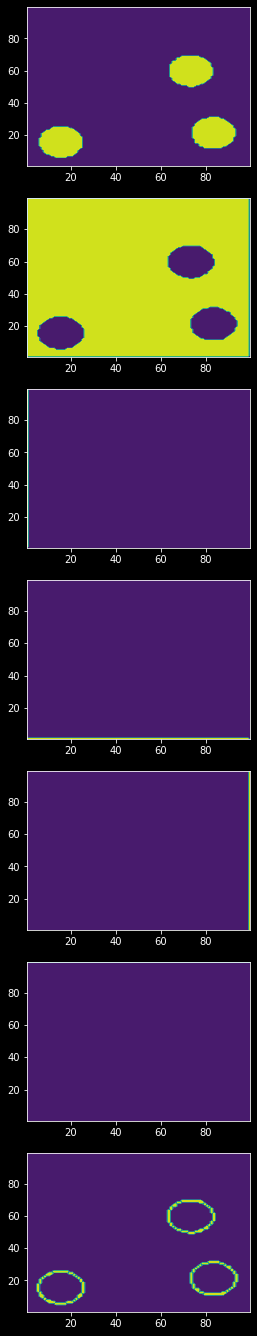

In [32]:
#hide
labels = [1, 2, 3, 4, 5, 6, 7]

fig, axs = plt.subplots(len(labels), 1, figsize=(4, 24))
for idx, label in enumerate(labels):
    im = axs[idx].contourf(x, y, labels_fields==label)
    # cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
    # fig.colorbar(im, cax=cax, orientation='horizontal')